# Deep Learning Forecasting

In [1]:
"""

@ author: Taehyeong Kim, Fusion Data Analytics and Artificial Intelligence Lab

"""

import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow.keras import Model, Sequential, Input, layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

import os
import random

seed=1011

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds()

import warnings
warnings.filterwarnings('ignore')

print("scikit-learn : ", sk.__version__)
print("tensorflow : ", tf.__version__)

scikit-learn :  0.24.2
tensorflow :  2.3.0


## Data Preprocessing

In [2]:
# Read data file
data = pd.read_excel("./sampling_data.xlsx", header=0, engine='openpyxl')
data.drop("item", axis=1, inplace=True)

data['2010sprt'] = data['2010ea'] * data['2010rate']
data['2011sprt'] = data['2011ea'] * data['2011rate']
data['2012sprt'] = data['2012ea'] * data['2012rate']
data['2013sprt'] = data['2013ea'] * data['2013rate']
data['2014sprt'] = data['2014ea'] * data['2014rate']
data['2015sprt'] = data['2015ea'] * data['2015rate']
data['2016sprt'] = data['2016ea'] * data['2016rate']

data.head()

,2010ea,2010rate,2010OP,2010SORT,2011ea,2011rate,2011OP,2011SORT,2012ea,2012rate,...,2016OP,2016SORT,Forecasting,2010sprt,2011sprt,2012sprt,2013sprt,2014sprt,2015sprt,2016sprt
0,0.0,0.000000,123488,2007,2.0,2.00,145911,2285,4.0,2.50,...,129946,2064,1,0.000000,4.00,10.0,6.0,28.0,0.0,4.0
1,3.0,1.000000,123488,2007,5.0,1.75,145911,2285,12.0,1.75,...,129946,2064,1,3.000000,8.75,21.0,38.0,42.0,15.0,8.0
2,0.0,0.000000,1080820,14283,0.0,0.00,1123702,12972,0.0,0.00,...,1038927,12553,1,0.000000,0.00,0.0,0.0,0.0,0.0,0.0
3,4.0,2.000000,123488,2007,5.0,2.50,145911,2285,1.0,1.00,...,129946,2064,1,8.000000,12.50,1.0,2.0,1.0,0.0,0.0
4,16.0,2.628571,255942,3168,1.0,1.00,261298,3404,4.0,2.50,...,231134,3135,1,42.057143,1.00,10.0,12.0,25.0,8.0,6.0


In [3]:
X1 = data.loc[:, ['2010ea', '2011ea', '2012ea', '2013ea', '2014ea', '2015ea']].values
X2 = data.loc[:, ['2010rate', '2011rate', '2012rate', '2013rate', '2014rate', '2015rate']].values
X3 = data.loc[:, ['2010OP', '2011OP', '2012OP', '2013OP', '2014OP', '2015OP']].values
X4 = data.loc[:, ['2010SORT', '2011SORT', '2012SORT', '2013SORT', '2014SORT', '2015SORT']].values
X5 = data.loc[:, ['2010sprt', '2011sprt', '2012sprt', '2013sprt', '2014sprt', '2015sprt']].values
X_2d_train=np.concatenate([X1, X2, X3, X4, X5], axis=1)

X1 = data.loc[:, ['2011ea', '2012ea', '2013ea', '2014ea', '2015ea', '2016ea']].values
X2 = data.loc[:, ['2011rate', '2012rate', '2013rate', '2014rate', '2015rate', '2016rate']].values
X3 = data.loc[:, ['2011OP', '2012OP', '2013OP', '2014OP', '2015OP', '2016OP']].values
X4 = data.loc[:, ['2011SORT', '2012SORT', '2013SORT', '2014SORT', '2015SORT', '2016SORT']].values
X5 = data.loc[:, ['2011sprt', '2012sprt', '2013sprt', '2014sprt', '2015sprt', '2016sprt']].values
X_2d_test=np.concatenate([X1, X2, X3, X4, X5], axis=1)

y_train = data["2016ea"].apply(lambda x : 0 if x<0.5 else 1).values
y_test = data.Forecasting.values

scaler_2d=MinMaxScaler().fit(X_2d_train)
X_2d_train=scaler_2d.transform(X_2d_train)
X_2d_test=scaler_2d.transform(X_2d_test)

X_3d_train=X_2d_train.reshape((len(X_2d_train), 5, 6)).transpose(0,2,1)
X_3d_test=X_2d_test.reshape((len(X_2d_test), 5, 6)).transpose(0,2,1)

X_3d_train.shape, X_3d_test.shape

((2000, 6, 5), (2000, 6, 5))

## Deep Learning

In [4]:
EPOCHS=100
BATCH_SIZE=len(data)

In [5]:
def rnn(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.SimpleRNN(32, input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def lstm(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def gru(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.GRU(32, input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def cnn1d(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.Conv1D(32, 3, kernel_initializer='he_normal',
                            input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model

def attrnn(trainX, trainy):
    set_seeds()
    inputs = Input(shape=(trainX.shape[1], trainX.shape[2]))
    x = layers.SimpleRNN(32, return_sequences=True)(inputs)
    input_dim = int(x.shape[2])
    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Flatten()(att)
    att = layers.Activation('softmax')(att)
    att = layers.RepeatVector(input_dim)(att)
    att = layers.Permute([2, 1])(att)
    att = layers.Multiply()([x, att])
    att = layers.Lambda(lambda x: K.sum(x, axis=-2), output_shape=(input_dim,))(att)
    x = layers.Dense(16, activation="relu")(att)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def attlstm(trainX, trainy):
    set_seeds()
    inputs = Input(shape=(trainX.shape[1], trainX.shape[2]))
    x = layers.LSTM(32, return_sequences=True)(inputs)
    input_dim = int(x.shape[2])
    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Flatten()(att)
    att = layers.Activation('softmax')(att)
    att = layers.RepeatVector(input_dim)(att)
    att = layers.Permute([2, 1])(att)
    att = layers.Multiply()([x, att])
    att = layers.Lambda(lambda x: K.sum(x, axis=-2), output_shape=(input_dim,))(att)
    x = layers.Dense(16, activation="relu")(att)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def attgru(trainX, trainy):
    set_seeds()
    inputs = Input(shape=(trainX.shape[1], trainX.shape[2]))
    x = layers.GRU(32, return_sequences=True)(inputs)
    input_dim = int(x.shape[2])
    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Flatten()(att)
    att = layers.Activation('softmax')(att)
    att = layers.RepeatVector(input_dim)(att)
    att = layers.Permute([2, 1])(att)
    att = layers.Multiply()([x, att])
    att = layers.Lambda(lambda x: K.sum(x, axis=-2), output_shape=(input_dim,))(att)
    x = layers.Dense(16, activation="relu")(att)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model

In [6]:
model1=rnn(X_3d_train, y_train)
model2=lstm(X_3d_train, y_train)
model3=gru(X_3d_train, y_train)
model4=cnn1d(X_3d_train, y_train)
model5=attrnn(X_3d_train, y_train)
model6=attlstm(X_3d_train, y_train)
model7=attgru(X_3d_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1216      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 176ms/step - loss: 0.7112 - accuracy: 0.4250 - val_loss: 0.7320 - val_accuracy: 0.2225
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.7039 - accuracy: 0.4881 - val_loss: 0.7151 - val_accuracy: 0.1925
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6975 - accuracy: 0.5088 - val

1/1 [==============================] - 0s 13ms/step - loss: 0.6577 - accuracy: 0.6575 - val_loss: 0.6471 - val_accuracy: 0.5525
Epoch 27/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6564 - accuracy: 0.6575 - val_loss: 0.6462 - val_accuracy: 0.5525
Epoch 28/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6552 - accuracy: 0.6575 - val_loss: 0.6456 - val_accuracy: 0.5525
Epoch 29/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6539 - accuracy: 0.6575 - val_loss: 0.6450 - val_accuracy: 0.5525
Epoch 30/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6527 - accuracy: 0.6575 - val_loss: 0.6445 - val_accuracy: 0.5525
Epoch 31/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6515 - accuracy: 0.6575 - val_loss: 0.6440 - val_accuracy: 0.5525
Epoch 32/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6503 - accuracy: 0.6575 - val_loss: 0.6439 - val_accuracy: 0.5525
Epoch 33/100
1/1 [========

Epoch 13/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6548 - accuracy: 0.6575 - val_loss: 0.6008 - val_accuracy: 0.5525
Epoch 14/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6526 - accuracy: 0.6575 - val_loss: 0.6053 - val_accuracy: 0.5525
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 6, 32)        1216        input_1[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 6, 1)         33          simple_rnn_1[0][0]               
___

Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6796 - accuracy: 0.6231 - val_loss: 0.6508 - val_accuracy: 0.5850
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6784 - accuracy: 0.6263 - val_loss: 0.6489 - val_accuracy: 0.5850
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6773 - accuracy: 0.6281 - val_loss: 0.6471 - val_accuracy: 0.5850
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6762 - accuracy: 0.6313 - val_loss: 0.6454 - val_accuracy: 0.5850
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6752 - accuracy: 0.6388 - val_loss: 0.6438 - val_accuracy: 0.5525
Epoch 10/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6741 - accuracy: 0.6562 - val_loss: 0.6421 - val_accuracy: 0.5525
Epoch 11/100
1/1 [==============================] - 0s 15ms/step - loss: 0.6731 - accuracy: 0.6575 - val_loss: 0.6405 - val_accuracy: 0.5525
Epoch 12/100
1/1 [

1/1 [==============================] - 0s 14ms/step - loss: 0.6750 - accuracy: 0.6575 - val_loss: 0.6519 - val_accuracy: 0.5525
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6734 - accuracy: 0.6575 - val_loss: 0.6500 - val_accuracy: 0.5525
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6719 - accuracy: 0.6575 - val_loss: 0.6483 - val_accuracy: 0.5525
Epoch 10/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6705 - accuracy: 0.6575 - val_loss: 0.6466 - val_accuracy: 0.5525
Epoch 11/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6690 - accuracy: 0.6575 - val_loss: 0.6451 - val_accuracy: 0.5525
Epoch 12/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6676 - accuracy: 0.6575 - val_loss: 0.6438 - val_accuracy: 0.5525
Epoch 13/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6662 - accuracy: 0.6575 - val_loss: 0.6428 - val_accuracy: 0.5525
Epoch 14/100
1/1 [==========

In [7]:
base_models = [model1, model2, model3, model4, model5, model6, model7]

model_name = ["RNN", "LSTM", "GRU", "1DCNN", "AttRNN", "AttLSTM", "AttGRU"]

for index, model in enumerate(base_models):
    
    y_pred=np.round(model.predict(X_3d_test))
    
    print("model:", model_name[index])
    print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("precision:", round(precision_score(y_test, y_pred), 3))
    print("recall:", round(recall_score(y_test, y_pred), 3))
    print("f1:", round(f1_score(y_test, y_pred), 3))
    print("")

model: RNN
accuracy: 0.646
precision: 0.614
recall: 0.789
f1: 0.691

model: LSTM
accuracy: 0.647
precision: 0.614
recall: 0.79
f1: 0.691

model: GRU
accuracy: 0.647
precision: 0.614
recall: 0.79
f1: 0.691

model: 1DCNN
accuracy: 0.636
precision: 0.62
recall: 0.701
f1: 0.658

model: AttRNN
accuracy: 0.621
precision: 0.611
recall: 0.664
f1: 0.637

model: AttLSTM
accuracy: 0.647
precision: 0.614
recall: 0.79
f1: 0.691

model: AttGRU
accuracy: 0.647
precision: 0.614
recall: 0.79
f1: 0.691



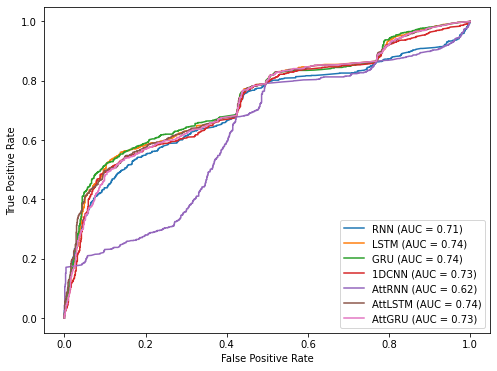

In [8]:
# ROC_Curve
fig = plt.figure(figsize=(8,6))
for index, model in enumerate(base_models):
    y_score=model.predict(X_3d_test)
    fpr, tpr, thresholds = roc_curve(y_test,  y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=model_name[index]+' (AUC = %0.2f)'% roc_auc)
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.savefig("./figure/DL_AUROC.png")
plt.show()

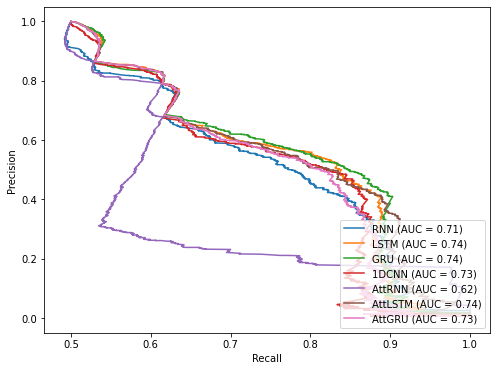

In [9]:
# Precision_Recall_Curve
fig = plt.figure(figsize=(8,6))
for index, model in enumerate(base_models):
    y_score=model.predict(X_3d_test)
    fpr, tpr, thresholds = precision_recall_curve(y_test,  y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=model_name[index]+' (AUC = %0.2f)'% roc_auc)
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
plt.savefig("./figure/DL_AUPR.png")
plt.show()